In [30]:
# Import Library
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [31]:
# Load Flower Dataset

(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    with_info=True,
    as_supervised=True,
)

print(metadata)

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


In [32]:
# Show label

class_names = metadata.features['label'].names
print("Class names: ", class_names)

Class names:  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [33]:
# Show shape

for image, label in train_ds.take(1):
  print('Image shape: ', image.numpy().shape)

Image shape:  (333, 500, 3)


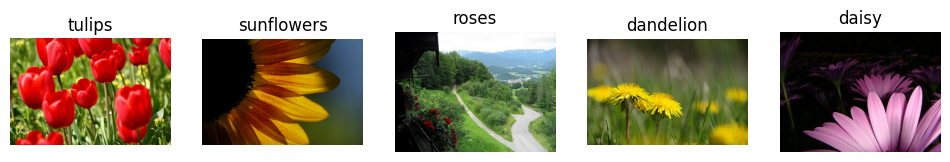

In [34]:
# Show example image for each class

sample_per_class = {}

for image, label in train_ds.take(100):
  label_name = class_names[label.numpy()]
  if label_name not in sample_per_class:
    sample_per_class[label_name] = image

  if len(sample_per_class) == len(class_names):
    break

plt.figure(figsize=(12, 4))
for i, (label_name, image) in enumerate(sample_per_class.items()):
  ax = plt.subplot(1, len(class_names), i + 1)
  plt.imshow(image)
  plt.title(label_name)
  plt.axis('off')

plt.show()

Text(0, 0.5, 'Number of Samples')

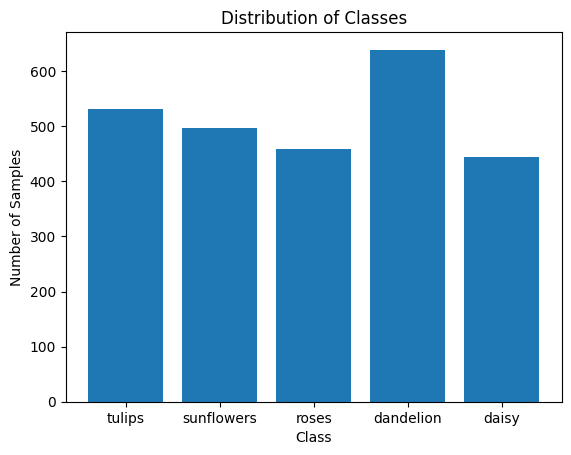

In [35]:
# Show distribution of classes

num_samples = {}

for image, label in train_ds:
  label_name = class_names[label.numpy()]
  if label_name not in num_samples:
    num_samples[label_name] = 1
  else:
    num_samples[label_name] += 1

plt.bar(num_samples.keys(), num_samples.values())
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Number of Samples")

In [36]:
# Resize and normalize image

IMG_SIZE = 224
BATCH_SIZE = 64

def preprocess(image, label):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

train_ds = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [37]:
# Show shape after resize and normalize

for image, label in train_ds.take(1):
  print('Image shape: ', image.numpy().shape)


Image shape:  (64, 224, 224, 3)


In [38]:
# Augment data

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2)
])

In [39]:
# Load base model

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

In [40]:
# Freeze base model

base_model.trainable = False

In [41]:
# Build model

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [42]:
# Compile mode

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [43]:
# Train model

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - accuracy: 0.1952 - loss: 2.3684 - val_accuracy: 0.3303 - val_loss: 1.7258
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.2610 - loss: 2.0496 - val_accuracy: 0.4174 - val_loss: 1.5036
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.3204 - loss: 1.8246 - val_accuracy: 0.4791 - val_loss: 1.3379
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.3552 - loss: 1.6742 - val_accuracy: 0.5245 - val_loss: 1.2023
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.4198 - loss: 1.5140 - val_accuracy: 0.5626 - val_loss: 1.1020
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.4754 - loss: 1.3739 - val_accuracy: 0.6098 - val_loss: 1.0184
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.4746 - loss: 1.3239 - val_accuracy: 0.6570 - val_loss: 0.9535
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.5149 - loss: 1.2305 - val_accuracy:

In [44]:
# Fine-tunning

base_model.trainable = True

for layer in base_model.layers[:-40]:
  layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop],

)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.4972 - loss: 1.3097 - val_accuracy: 0.7296 - val_loss: 0.7317
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 0.5986 - loss: 1.0581 - val_accuracy: 0.7368 - val_loss: 0.6811
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.6838 - loss: 0.8806 - val_accuracy: 0.7532 - val_loss: 0.6386
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.6821 - loss: 0.8130 - val_accuracy: 0.7586 - val_loss: 0.5989
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 0.7147 - loss: 0.7413 - val_accuracy: 0.7786 - val_loss: 0.5670
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.7531 - loss: 0.6772 - val_accuracy: 0.7804 - val_loss: 0.5439
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.7493 - loss: 0.6513 - val_accuracy: 0.7949 - val_loss: 0.5175
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.7588 - loss: 0.6382 - val_acc

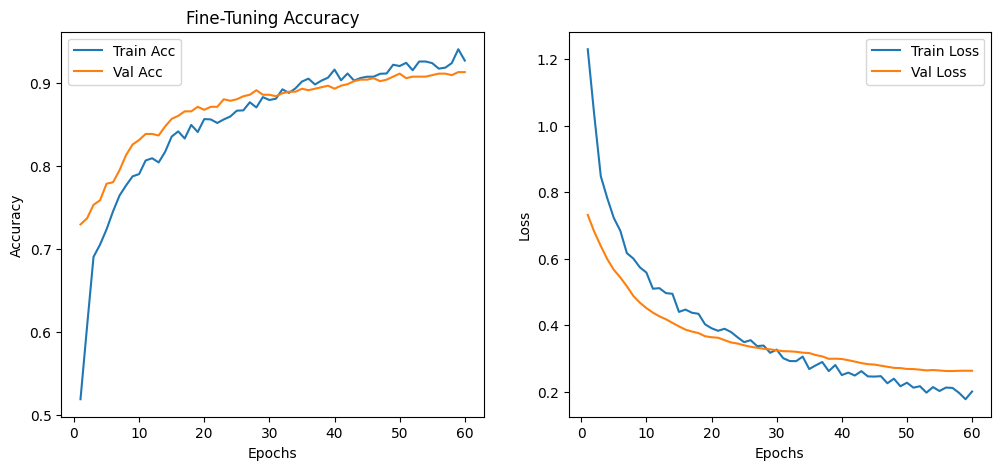

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.title("Fine-Tuning Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [46]:
# Evaluate model

loss, accuracy = model.evaluate(test_ds)

print('Test accuracy :', accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9198 - loss: 0.2468
Test accuracy : 0.9345454573631287


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


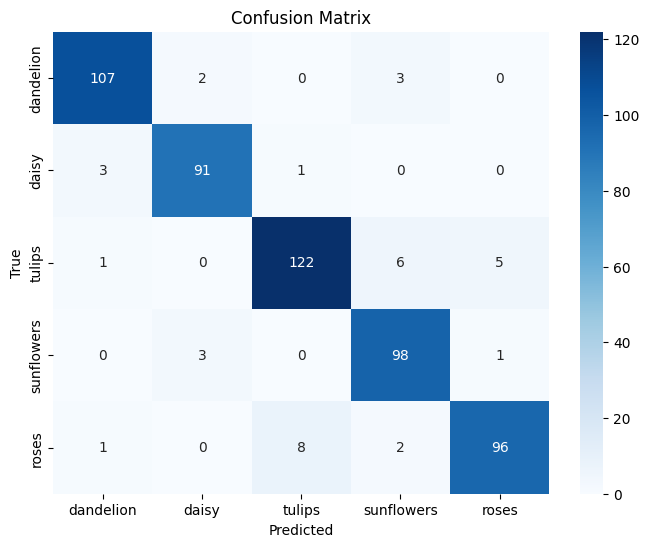

In [47]:
# Error analysis

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_classes)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

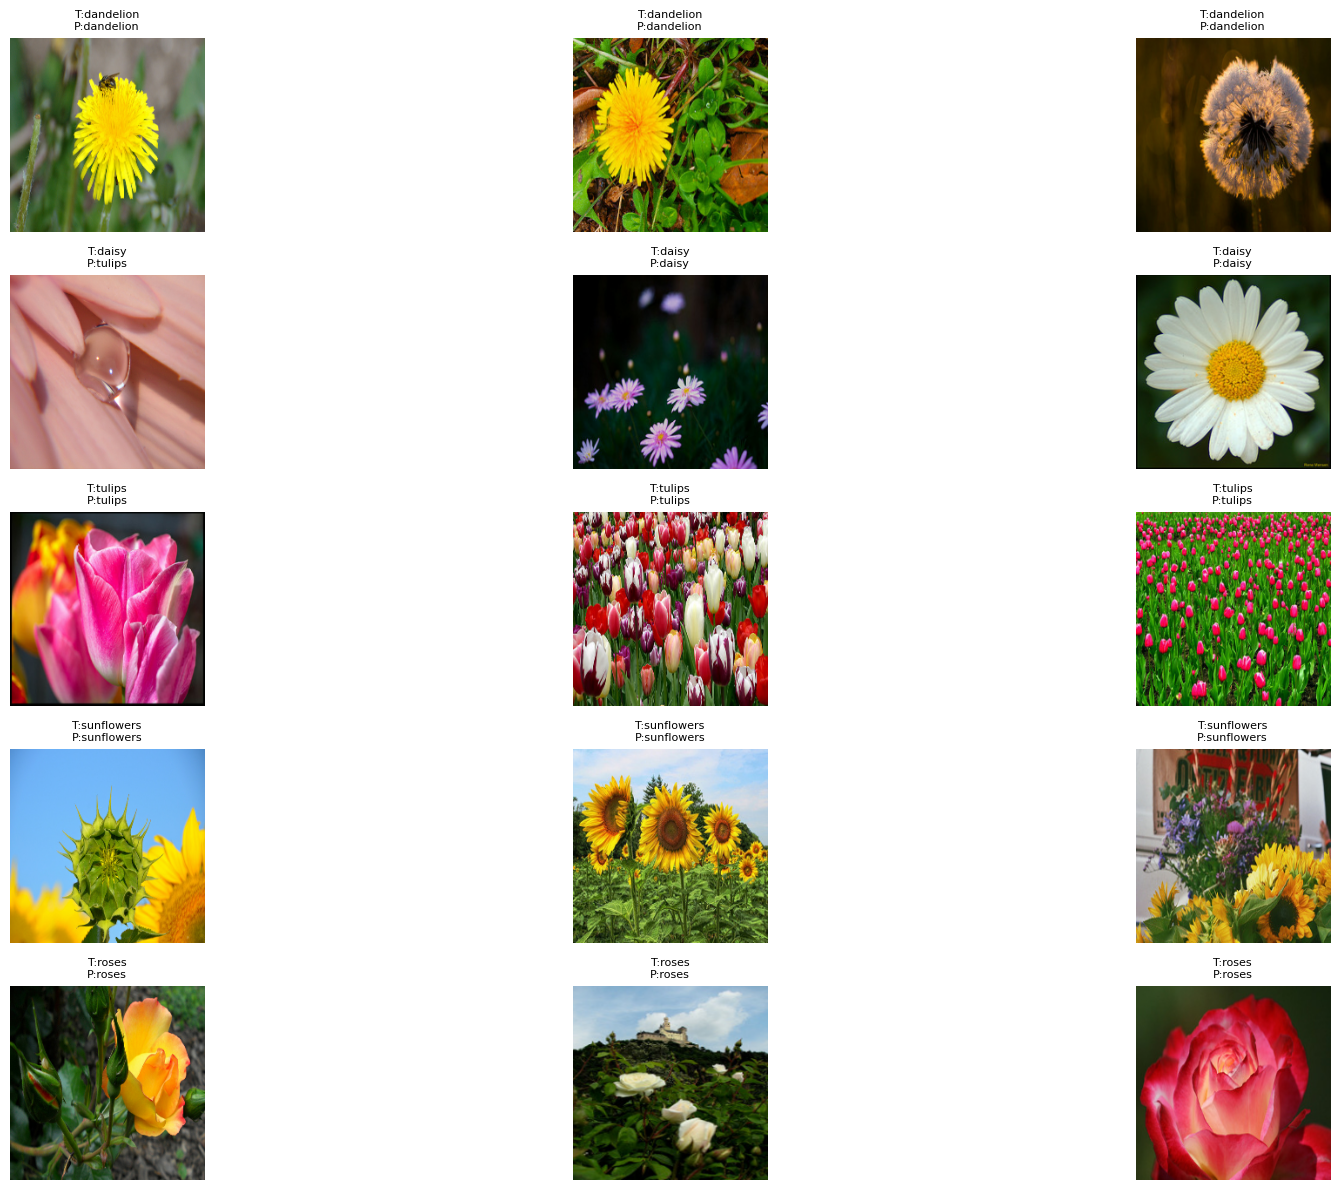

In [48]:
# Do 3 predict for each class

images, labels = next(iter(test_ds))

sample_images = {cls: [] for cls in range(len(class_names))}
sample_labels = {cls: [] for cls in range(len(class_names))}

for img, label in zip(images, labels):
    cls = int(label.numpy())
    if len(sample_images[cls]) < 3:
        sample_images[cls].append(img)
        sample_labels[cls].append(cls)

    if all(len(sample_images[c]) >= 3 for c in sample_images):
        break

plt.figure(figsize=(20, 12))

plot_idx = 1
for cls in sample_images.keys():
    true_label = class_names[cls]
    for img in sample_images[cls]:
        pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
        pred_class = np.argmax(pred, axis=1)[0]
        pred_label = class_names[pred_class]

        plt.subplot(len(class_names), 3, plot_idx)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T:{true_label}\nP:{pred_label}", fontsize=8)
        plot_idx += 1
plt.tight_layout()
plt.show()


In [50]:
# Save model

model.save('flower_model.h5')